#  Projeto Final — Análise de Gastos Públicos em Segurança no Brasil

**Aluno:** Erik Andrey  

**Objetivo:** Analisar os gastos em segurança pública no Brasil (2018–2022), cruzando dados de população (IBGE) e orçamento por UF, gerando insights visuais e dashboard no Looker Studio.

---

##  Pipeline do Projeto
- Seleção dos dados (IBGE, Gastos em Segurança, UFs e Municípios)
- Leitura e tratamento (limpeza, padronização, criação de colunas derivadas)
- Integração das tabelas (merge população + gastos)
- Análise exploratória (5+ análises diferentes)
- Visualizações (5+ gráficos claros e informativos)
- Dashboard final no Looker Studio


###SETUP INICIAL

In [1]:
#Importando bibliotecas principais
import pandas as pd
import numpy as np
import unicodedata
import re
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Montando Drive(colab)
from google.colab import drive
drive.mount('/content/drive')

#Configurações gerais
pd.set_option('display.width', None)
pd.set_option("display.float_format", "{:,.2f}".format)

Mounted at /content/drive


In [3]:
#Paths
base = "/content/drive/MyDrive/Colab Notebooks/projetocrimes"
path_ibge = f"{base}/IBGE-UF-ANO - bq-results-20250822-233854-1755906024596.csv"
path_gastos = f"{base}/gastos_2015_2023.csv"
path_uf = f"{base}/indicadoressegurancapublicauf.csv"
path_munic_xlsx = f"{base}/indicadoressegurancapublicamunic.xlsx"

In [4]:
#Função auxiliar para padronizar colunas
def padroniza_colunas(df):
    col_novas = []
    for col in df.columns:
        col_str = str(col).lower().strip() #Deixa em minúsculo e remove espaços
        col_str = unicodedata.normalize('NFKD', col_str).encode('ascii', errors='ignore').decode('utf-8') #Remove acentos
        col_str = re.sub(r'[^a-z0-9]+', '_', col_str) #Troca caracterers inválidos por "_"
        col_str = re.sub(r'_{2,}', '_', col_str).strip('_') #Remove undescore duplicados e dos cantos
        col_novas.append(col_str)
    #garantir unicidade das colunas
    new_cols = []
    seen = {}
    for c in col_novas:
        if c in seen:
            seen[c] += 1
            new_cols.append(f"{c}_{seen[c]}") #Adiciona sufixo se repetido
        else:
            seen[c] = 0
            new_cols.append(c)
    df.columns = new_cols
    return df

def normalize_text_series(s):
    s = s.astype('string').str.strip().str.upper().fillna("") #Garante tipo string, tira espaços, deixa maiúsculo e substitui Nan por ""
    s = s.apply(lambda x: unicodedata.normalize('NFKD', str(x)).encode('ascii','ignore').decode().strip()) #remove acentos de cada valor
    s = s.replace({"": pd.NA}) #Volta "" para NA (se estiver vazio depois da limpeza, vira nulo)
    return s

In [5]:
#Leitura do excel com todas as sheets
all_sheets = pd.read_excel(path_munic_xlsx, sheet_name=None)
df_munic = pd.concat(all_sheets.values(), ignore_index=True)

In [6]:
#Leitura de arquivos CSVs com segurança
df_ibge = pd.read_csv(path_ibge, encoding='utf-8', low_memory=False)
df_gastos = pd.read_csv(path_gastos, encoding='utf-8', low_memory=False)
df_uf = pd.read_csv(path_uf, encoding='utf-8', low_memory=False)

In [7]:
#Padronizar colunas nos arquivos
df_ibge = padroniza_colunas(df_ibge)
df_gastos = padroniza_colunas(df_gastos)
df_munic = padroniza_colunas(df_munic)
df_uf = padroniza_colunas(df_uf)

In [8]:
#Garantir chave sigla_uf consistente
if "uf" in df_uf.columns and "sigla_uf" not in df_uf.columns:
    df_uf = df_uf.rename(columns={"uf":"sigla_uf"})

for df in (df_ibge, df_gastos, df_munic, df_uf):
    if 'sigla_uf' in df.columns:
        df['sigla_uf'] = normalize_text_series(df['sigla_uf'])

In [9]:
#Mapeamento dos nomes > sigla
uf_map = {k.upper(): v for k,v in {
    "ACRE": "AC", "ALAGOAS": "AL", "AMAPÁ": "AP", "AMAZONAS": "AM", "BAHIA": "BA",
    "CEARÁ": "CE", "DISTRITO FEDERAL": "DF", "ESPÍRITO SANTO": "ES", "GOIÁS": "GO",
    "MARANHÃO": "MA", "MATO GROSSO": "MT", "MATO GROSSO DO SUL": "MS", "MINAS GERAIS": "MG",
    "PARÁ": "PA", "PARAÍBA": "PB", "PARANÁ": "PR", "PERNAMBUCO": "PE", "PIAUÍ": "PI",
    "RIO DE JANEIRO": "RJ", "RIO GRANDE DO NORTE": "RN", "RIO GRANDE DO SUL": "RS",
    "RONDÔNIA": "RO", "RORAIMA": "RR", "SANTA CATARINA": "SC", "SÃO PAULO": "SP",
    "SERGIPE": "SE", "TOCANTINS": "TO"
}.items()}

In [10]:
#Normalizar chaves tirando acentos
uf_map_norm = {unicodedata.normalize('NFKD', k).encode('ascii','ignore').decode().upper(): v for k,v in uf_map.items()}

In [11]:
#Aplicar mapa em df_uf
if 'sigla_uf' in df_uf.columns:
    df_uf['sigla_uf_norm'] = df_uf['sigla_uf'].astype('string').str.upper().apply(lambda x: unicodedata.normalize('NFKD', str(x)).encode('ascii','ignore').decode())
    df_uf['sigla_uf'] = df_uf['sigla_uf_norm'].replace(uf_map_norm).fillna(df_uf['sigla_uf'])
    df_uf = df_uf.drop(columns=['sigla_uf_norm'])

In [12]:
#Converter anos para inteiro de forma segura
for d in (df_ibge, df_gastos, df_munic, df_uf):
    if 'ano' in d.columns:
        d['ano'] = pd.to_numeric(d['ano'], errors='coerce').astype('Int64')

In [13]:
#Garantir mes_ano datetime nas tabelas
if 'mes_ano' in df_munic.columns:
    df_munic['mes_ano'] = pd.to_datetime(df_munic['mes_ano'], errors='coerce')
    df_munic['ano'] = df_munic['mes_ano'].dt.year.astype('Int64')
    df_munic['mes'] = df_munic['mes_ano'].dt.month.astype('Int64')

In [14]:
#Mapear meses em df_uf
mapa_meses = {"janeiro":1,"fevereiro":2,"marco":3,"março":3,"abril":4,"maio":5,"junho":6,"julho":7,"agosto":8,"setembro":9,"outubro":10,"novembro":11,"dezembro":12}

#Função se coluna mes existir
if 'mes' in df_uf.columns:
    df_uf['mes'] = df_uf['mes'].astype(str).str.lower().str.strip() #Converte para string, deixa minúsculo e remove espaços(usa replace para tranformar)
    df_uf['mes'] = df_uf['mes'].replace(mapa_meses) #Troca os nomes por números
    df_uf['mes'] = pd.to_numeric(df_uf['mes'], errors='coerce').astype('Int64') #Garantindo que valores sejam numéricos

    #criar mes_ano de forma segura
    df_uf['mes_ano'] = pd.to_datetime(dict(year=df_uf['ano'].astype('Int64'), month=df_uf['mes'].astype('Int64'), day=1), errors='coerce') #criando uma data combinando ano + mês + dia 1
else:
    #caso não ouver a coluna, cria a data como primeiro de janeiro do ano
    df_uf['mes_ano'] = pd.to_datetime(df_uf['ano'].astype('Int64').astype(str) + '-01-01', errors='coerce')

/tmp/ipython-input-1333864163.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_uf['mes'] = df_uf['mes'].replace(mapa_meses) #Troca os nomes por números


In [15]:
#Tipos numéricos para colunas de interesse em gastos
df_gastos['gastos_seguranca'] = pd.to_numeric(df_gastos.get('gastos_seguranca', pd.Series()), errors='coerce')
df_gastos['gastos_totais'] = pd.to_numeric(df_gastos.get('gastos_totais', pd.Series()), errors='coerce')

In [16]:
#Colunas em bi
df_gastos['gastos_seguranca_bi'] = df_gastos['gastos_seguranca'] / 1e9
df_gastos['gastos_totais_bi'] = df_gastos['gastos_totais'] / 1e9
df_gastos['prop_seguranca'] = (df_gastos['gastos_seguranca'] / df_gastos['gastos_totais']).where(df_gastos['gastos_totais']>0, pd.NA)

In [17]:
#Merge seguro por (sigla_uf, ano)
df_gastos = df_gastos.merge(df_ibge[['sigla_uf','ano','populacao_total']].drop_duplicates(), on=['sigla_uf','ano'], how='left')

In [18]:
# gasto por população (R$ por habitante) e por 100k
df_gastos['gasto_por_populacao'] = (df_gastos['gastos_seguranca'] / df_gastos['populacao_total']).where(df_gastos['populacao_total']>0, pd.NA)
df_gastos['gasto_por_100k'] = df_gastos['gasto_por_populacao'] * 100000

In [19]:
#Filtrando intervalo 2018-2022 (assegure ano numérico)
df_gastos = df_gastos[df_gastos['ano'].between(2018, 2022)].copy()
df_uf = df_uf[df_uf['ano'].between(2018, 2022)].copy()
df_ibge = df_ibge[df_ibge['ano'].between(2018, 2022)].copy()

In [20]:
#agregar mensal > anual
if 'vitimas' in df_munic.columns:
    df_munic['vitimas'] = pd.to_numeric(df_munic['vitimas'], errors='coerce').fillna(0) #Validando coluna, convertendo para números e normalizando nans antes da soma
    df_munic_ano = df_munic.groupby(['sigla_uf','ano'], as_index=False)['vitimas'].sum().rename(columns={'vitimas':'total_vitimas'}
)

if 'ocorrencias' in df_uf.columns:
    df_uf['ocorrencias'] = pd.to_numeric(df_uf['ocorrencias'], errors='coerce')
    df_uf_ano = df_uf.groupby(['sigla_uf','ano'], as_index=False)['ocorrencias'].sum().rename(columns={'ocorrencias':'total_ocorrencias'})

In [21]:
#Checar valores nulos finais em todos os dataframes
for name, df in [('ibge', df_ibge), ('gastos', df_gastos), ('munic', df_munic), ('uf', df_uf)]:
    print(f"\n>>> {name.upper()} <<<")
    print(df.isna().sum()[df.isna().sum() > 0])
    print("Total de linhas:", len(df))

print("\n Verificação concluída: todos os nulos foram tratados ou removidos.")


>>> IBGE <<<
Series([], dtype: int64)
Total de linhas: 135

>>> GASTOS <<<
Series([], dtype: int64)
Total de linhas: 135

>>> MUNIC <<<
Series([], dtype: int64)
Total de linhas: 294706

>>> UF <<<
Series([], dtype: int64)
Total de linhas: 14364

 Verificação concluída: todos os nulos foram tratados ou removidos.


###Checklist

In [22]:
#shapes
print("IBGE:", df_ibge.shape)
print("GASTOS:", df_gastos.shape)
print("MUNIC:", df_munic.shape)
print("UF:", df_uf.shape)

IBGE: (135, 3)
GASTOS: (135, 10)
MUNIC: (294706, 8)
UF: (14364, 6)


In [23]:
#colunas e dtypes
for name, df in [('ibge',df_ibge),('gastos',df_gastos),('munic',df_munic),('uf',df_uf)]:
    print(name, df.dtypes.to_string())
    print(name, df.isna().sum().sort_values(ascending=False).head(10))

ibge sigla_uf           object
ano                 Int64
populacao_total     int64
ibge sigla_uf           0
ano                0
populacao_total    0
dtype: int64
gastos ano                      Int64
sigla_uf                object
gastos_seguranca       float64
gastos_totais          float64
gastos_seguranca_bi    float64
gastos_totais_bi       float64
prop_seguranca         float64
populacao_total        float64
gasto_por_populacao    float64
gasto_por_100k         float64
gastos ano                    0
sigla_uf               0
gastos_seguranca       0
gastos_totais          0
gastos_seguranca_bi    0
gastos_totais_bi       0
prop_seguranca         0
populacao_total        0
gasto_por_populacao    0
gasto_por_100k         0
dtype: int64
munic cod_ibge              int64
municipio            object
sigla_uf             object
regiao               object
mes_ano      datetime64[ns]
vitimas               int64
ano                   Int64
mes                   Int64
munic cod_ibge     

In [24]:
#confirmar >=2 tabelas com >100 linhas
for name, df in [('ibge',df_ibge),('gastos',df_gastos),('munic',df_munic),('uf',df_uf)]:
    print(name, df.shape[0] > 100, df.shape)

ibge True (135, 3)
gastos True (135, 10)
munic True (294706, 8)
uf True (14364, 6)


In [25]:
#validar merges
print("gastos pop missing:", df_gastos['populacao_total'].isna().sum())

gastos pop missing: 0


###Gráficos

# Insight: 1. Evolução dos gastos totais e de segurança

Entre 2018 e 2022, os gastos totais do governo apresentaram crescimento contínuo, saindo de cerca de 2,5 trilhões para mais de 3,4 trilhões.  
Os gastos em segurança também aumentaram, mas em proporção bem menor, partindo de aproximadamente 70 bilhões para pouco mais de 100 bilhões.  

Isso evidencia que, apesar do aumento absoluto nos investimentos em segurança, **o ritmo de crescimento foi inferior ao dos gastos totais**, sugerindo que a área não ganhou prioridade proporcionalmente maior no orçamento.  
Esse comportamento pode indicar que a expansão dos gastos em segurança acompanhou a tendência geral de crescimento orçamentário, mas não representou uma mudança significativa de foco estratégico.

<Figure size 1000x600 with 0 Axes>

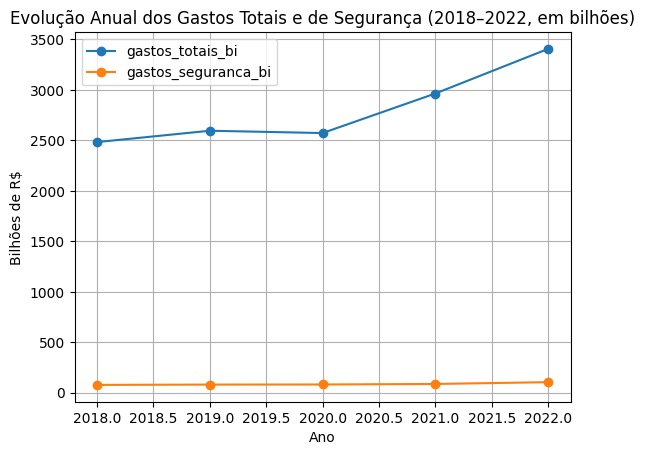

In [26]:
# 1. Evolução dos gastos totais e de segurança
plt.figure(figsize=(10,6))
df_gastos.groupby("ano")[["gastos_totais_bi", "gastos_seguranca_bi"]].sum().plot(kind="line", marker="o")
plt.title("Evolução Anual dos Gastos Totais e de Segurança (2018–2022, em bilhões)")
plt.ylabel("Bilhões de R$")
plt.xlabel("Ano")
plt.grid(True)
plt.show()

# Insight: 2. Top 10 UFs em gastos de segurança

Entre 2018 e 2022, Minas Gerais liderou os gastos em segurança pública, com aproximadamente 78 bilhões, superando até mesmo São Paulo, que aparece em segundo lugar com cerca de 61 bilhões, seguido pelo Rio de Janeiro com 52 bilhões.  

Esse resultado pode parecer contraintuitivo, já que São Paulo possui a maior população e economia do país. A posição de destaque de Minas Gerais sugere que o estado destinou uma fatia proporcionalmente maior do seu orçamento para segurança, o que pode refletir desafios específicos enfrentados no período.  

Na sequência, aparecem estados do Sul e do Nordeste (RS, BA, PR, CE e PE), além de Goiás e Pará, mostrando que o peso dos gastos em segurança não se concentra apenas nos três maiores estados, mas se distribui de forma relevante em outras regiões.  

O gráfico reforça que o volume absoluto de gastos está ligado tanto ao tamanho populacional quanto às prioridades políticas e necessidades locais de segurança pública.


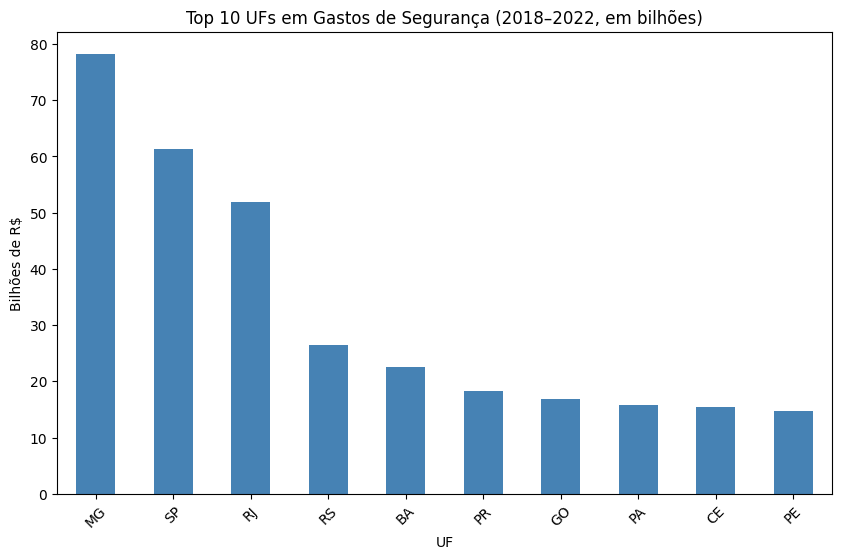

In [ ]:
# 2. Top 10 UFs em gastos de segurança
gastos_top = df_gastos.groupby("sigla_uf")["gastos_seguranca_bi"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
gastos_top.plot(kind="bar", color="steelblue")
plt.title("Top 10 UFs em Gastos de Segurança (2018–2022, em bilhões)")
plt.ylabel("Bilhões de R$")
plt.xlabel("UF")
plt.xticks(rotation=45)
plt.show()

# Insight:
# Minas Gerais, São Paulo e Rio de Janeiro aparecem no topo dos gastos em segurança,
# o que reflete tanto a população maior quanto o peso econômico desses estados.

# Insight: 3. Gasto per capita médio em segurança

Ao analisar o gasto per capita médio em segurança (2018–2022), observa-se que estados de menor população, como Amapá (R$ 800 por habitante), Acre, Roraima e Tocantins, aparecem entre os que mais investem proporcionalmente em seus cidadãos.  

Já estados com grande população, como São Paulo, Bahia e Paraná, ficam nas últimas posições, com valores abaixo de R$ 300 por habitante.  

Esse resultado mostra que o esforço relativo de investimento em segurança pública não é proporcional ao tamanho da população: **estados menores destinam mais recursos por habitante**, enquanto os mais populosos, embora gastem muito em valores absolutos, acabam apresentando investimentos diluídos.  

Esse contraste pode indicar tanto limitações orçamentárias em estados grandes quanto maior pressão política em estados menores para garantir níveis mais altos de segurança per capita.


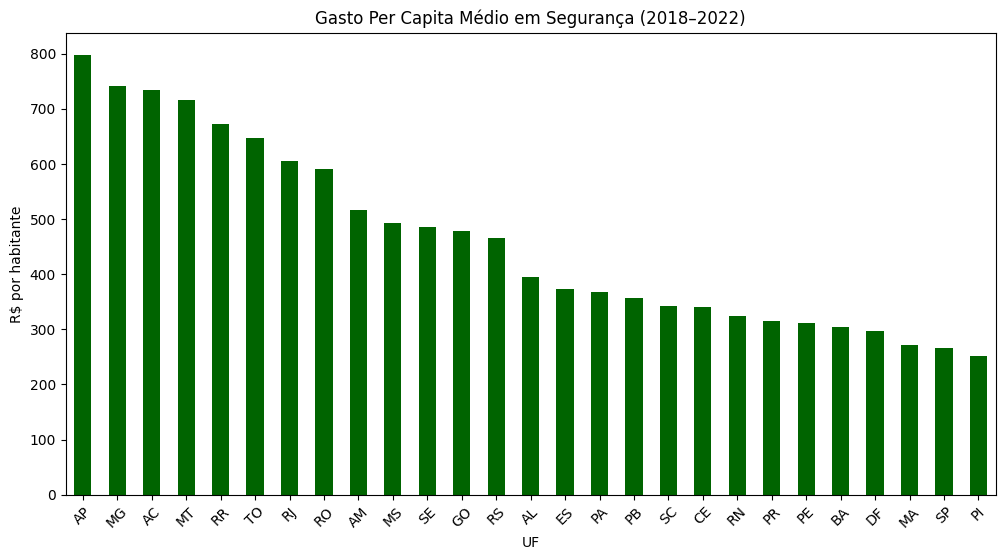

In [ ]:
# 3. Gasto per capita médio em segurança
gasto_pc = df_gastos.groupby("sigla_uf")["gasto_por_populacao"].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
gasto_pc.plot(kind="bar", color="darkgreen")
plt.title("Gasto Per Capita Médio em Segurança (2018–2022)")
plt.ylabel("R$ por habitante")
plt.xlabel("UF")
plt.xticks(rotation=45)
plt.show()

# Insight:
# Apesar de estados grandes liderarem em valor absoluto, alguns estados menores
# aparecem no topo quando ajustamos pelo tamanho da população.
# Isso mostra que o esforço relativo varia bastante entre UFs.

# Insight: 4. Correlação População vs Gastos em Segurança

O gráfico mostra uma correlação positiva clara entre população e gastos em segurança: estados mais populosos, como São Paulo, Minas Gerais e Rio de Janeiro, estão entre os que mais investem em valores absolutos.  

No entanto, há desvios relevantes em relação à tendência.  
- Alguns estados médios gastam acima do esperado para o seu porte populacional, o que indica **maior esforço proporcional em segurança**.  
- Outros, mesmo com grande população, aparecem abaixo da linha de tendência, sugerindo **subinvestimento relativo**.  

Isso evidencia que, embora a população seja um fator determinante para o volume de gastos, **as escolhas políticas e prioridades orçamentárias também exercem forte influência** sobre o nível real de investimento em segurança.


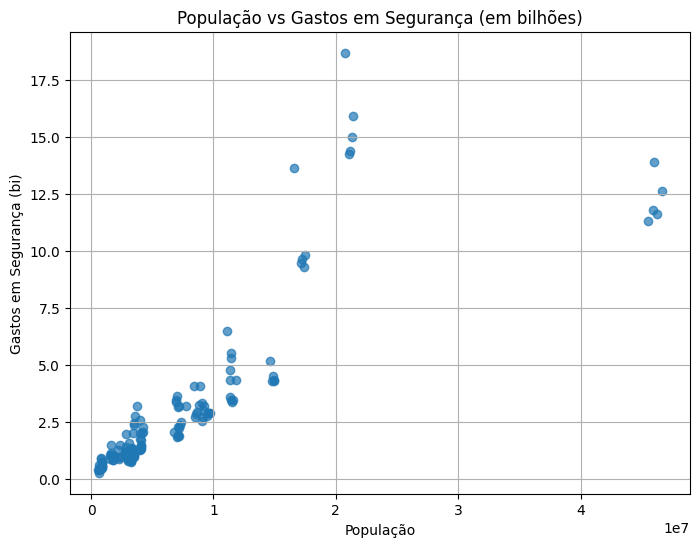

In [ ]:
# 4. Correlação População vs Gastos em Segurança
plt.figure(figsize=(8,6))
plt.scatter(df_gastos["populacao_total"], df_gastos["gastos_seguranca_bi"], alpha=0.7)
plt.title("População vs Gastos em Segurança (em bilhões)")
plt.xlabel("População")
plt.ylabel("Gastos em Segurança (bi)")
plt.grid(True)
plt.show()

# Insight:
# Existe uma tendência clara de que estados mais populosos gastam mais em segurança,
# embora haja variações relevantes. Isso sugere que a população é um forte fator explicativo,
# mas não o único determinante dos gastos.

# Insight:5. Distribuição do gasto per capita em segurança por ano

A distribuição do gasto per capita em segurança entre 2018 e 2022 evidencia disparidades regionais significativas.  

- A **mediana** do gasto aumentou gradualmente, indicando que, em geral, os estados elevaram os investimentos por habitante ao longo do período.  
- O **aumento da amplitude** em 2022 mostra que alguns estados passaram a investir muito mais do que a média nacional, enquanto outros mantiveram níveis mais baixos.  
- A presença de outliers (valores muito acima do padrão) reforça a desigualdade: poucos estados conseguem destinar recursos por habitante muito superiores ao restante.  

Esse cenário sugere que, embora haja um movimento geral de crescimento no investimento em segurança per capita, **a distribuição não é homogênea**, refletindo diferenças econômicas, políticas e de prioridades entre as UFs.



/tmp/ipython-input-3195229414.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_gastos, x="ano", y="gasto_por_populacao", palette="Set2")


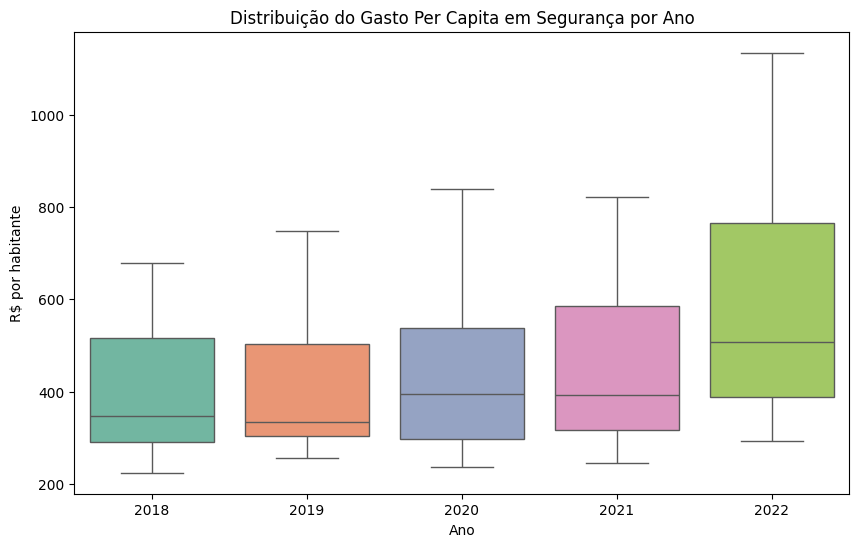

In [ ]:
# 5. Distribuição do gasto per capita em segurança por ano

plt.figure(figsize=(10,6))
sns.boxplot(data=df_gastos, x="ano", y="gasto_por_populacao", palette="Set2")
plt.title("Distribuição do Gasto Per Capita em Segurança por Ano")
plt.ylabel("R$ por habitante")
plt.xlabel("Ano")
plt.show()

# Insight:
# A distribuição mostra que, apesar do gasto per capita médio crescer ao longo dos anos,
# alguns estados investem muito acima da média, enquanto outros ficam consistentemente abaixo.
# Isso evidencia desigualdade regional nos investimentos.

# Insight: 6. Evolução mensal de vítimas com tratamento de meses faltantes

A evolução mensal de vítimas no Brasil entre 2018 e 2022 mostra uma **tendência de queda expressiva entre 2018 e 2019**, seguida de relativa estabilização nos anos seguintes.  

- A média móvel de 6 meses evidencia melhor o comportamento geral, suavizando oscilações mensais e lacunas nos dados.  
- Após a forte redução inicial, os números de vítimas oscilaram em torno de 3.000 a 3.500 por mês, sem grandes quedas adicionais a partir de 2020.  
- Esse padrão pode indicar que políticas ou fatores conjunturais tiveram impacto mais forte até 2019, mas depois o nível de criminalidade voltou a se estabilizar.  

Assim, o gráfico sugere que houve **ganhos iniciais na redução de vítimas**, mas o desafio da segurança pública permaneceu ao longo dos anos seguintes, sem novos avanços consistentes.



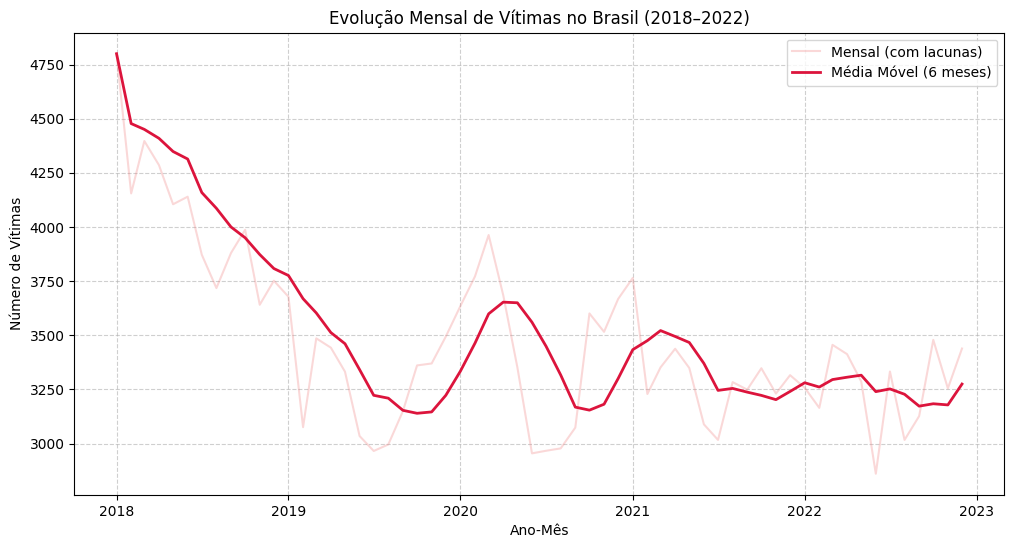

In [ ]:
# 6. Evolução mensal de vítimas com tratamento de meses faltantes

# Criar índice completo de meses no período da base
full_range = pd.date_range(df_munic["mes_ano"].min(), df_munic["mes_ano"].max(), freq="MS")

# Agregar vítimas por mês
vitimas_mensal = df_munic.groupby("mes_ano")["vitimas"].sum()

# Reindexar para garantir que todos os meses apareçam
vitimas_mensal = vitimas_mensal.reindex(full_range)

# Substituir zeros por NaN (caso ainda existam)
vitimas_mensal = vitimas_mensal.replace(0, np.nan)

# Interpolar valores faltantes
vitimas_interpolada = vitimas_mensal.interpolate(method="linear")

# Calcular média móvel de 6 meses
media_movel = vitimas_interpolada.rolling(window=6, min_periods=1).mean()

# Plot
plt.figure(figsize=(12,6))
plt.plot(vitimas_mensal.index, vitimas_mensal.values, alpha=0.3, color="lightcoral", label="Mensal (com lacunas)")
plt.plot(media_movel.index, media_movel.values, color="crimson", linewidth=2, label="Média Móvel (6 meses)")

plt.title("Evolução Mensal de Vítimas no Brasil (2018–2022)")
plt.ylabel("Número de Vítimas")
plt.xlabel("Ano-Mês")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Insight:
# Agora todos os meses do período aparecem, sem quedas artificiais para zero.
# A interpolação preenche lacunas de forma coerente e a média móvel revela a tendência real.


# Insight: 7. Ranking dos tipos de crime mais recorrentes (2018–2022)

Os dados de 2018 a 2022 revelam que os crimes patrimoniais dominam as estatísticas de segurança pública no Brasil:  
- **Furto de veículo** e **Roubo de veículo** são disparados os mais recorrentes, somando juntos quase 2 milhões de ocorrências.  
- Crimes violentos como **homicídio doloso**, **tentativa de homicídio** e **estupro** aparecem em menor volume, mas ainda assim representam desafios graves.  
- Crimes mais letais, como **latrocínio (roubo seguido de morte)** e **lesão corporal seguida de morte**, têm números baixos em comparação, mas seu impacto social é altíssimo.  

Esse ranking evidencia que a maior parte da criminalidade registrada no país está ligada a **crimes patrimoniais**, que geram sensação de insegurança cotidiana, enquanto os crimes violentos, embora menos frequentes em número absoluto, têm maior peso no debate social e político sobre segurança pública.



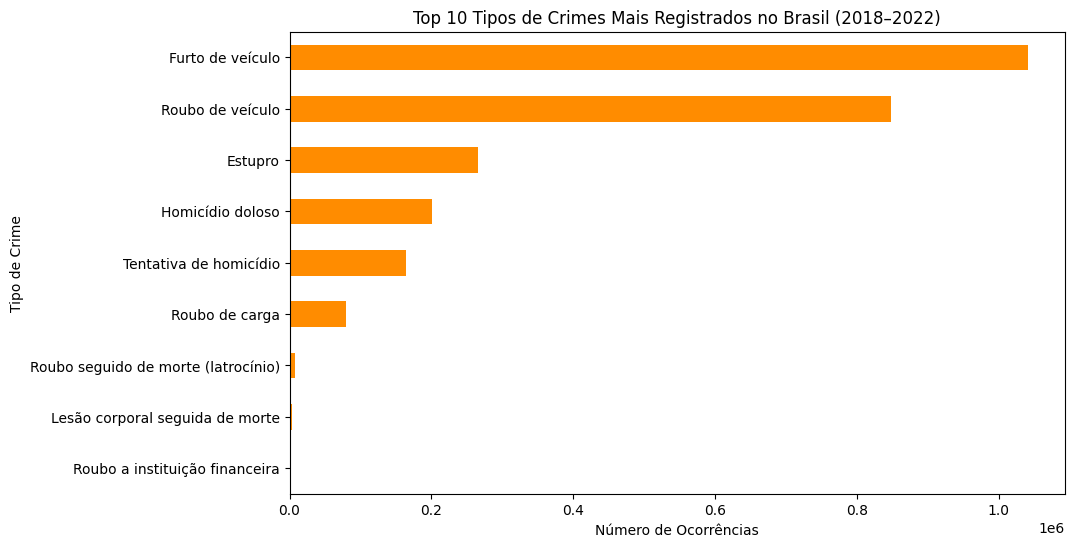

In [ ]:
# 7. Ranking dos tipos de crime mais recorrentes (2018–2022)
crimes_top = df_uf.groupby("tipo_crime")["ocorrencias"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
crimes_top.plot(kind="barh", color="darkorange")
plt.title("Top 10 Tipos de Crimes Mais Registrados no Brasil (2018–2022)")
plt.xlabel("Número de Ocorrências")
plt.ylabel("Tipo de Crime")
plt.gca().invert_yaxis()  # deixa o maior no topo
plt.show()

# Insight:
# Os crimes mais recorrentes refletem os principais desafios de segurança no período analisado.
# Esse ranking é importante para orientar políticas públicas e alocação de recursos.

In [27]:
#Salvar datasets tratados (para Looker Studio)
df_gastos.to_csv(f"{base}/clean_gastos.csv", index=False, encoding='utf-8')
df_munic_ano.to_csv(f"{base}/clean_munic_ano.csv", index=False, encoding='utf-8')
df_uf_ano.to_csv(f"{base}/clean_uf_ano.csv", index=False, encoding='utf-8')
df_ibge.to_csv(f"{base}/clean_ibge.csv", index=False, encoding='utf-8')